### Best Model and Imbalance Handling
#### From `notebooks\3_model_exploration.ipynb`
- SMOTE + XGBoost

### Steps
1. reproduce the feature engineering again in each K-fold
2. train and preprocess properly to ensure no data leakage
3. evaluation

In [3]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack

# NLP preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
import wordninja

lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

TEXT_COLS = ['title', 'description', 'requirements', 'benefits', 'company_profile']
CATEGORICAL_COLS = ['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'location', 'department']
BINARY_COLS = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Er

In [4]:
def handle_nulls_upfront(df):
    """
    Handle all null values upfront before any processing.
    This ensures consistent null handling throughout the pipeline.
    
    Strategy:
    - Text columns → empty string ""
    - Categorical columns → "unknown"
    - salary_range → "unknown"
    - Binary columns → keep as-is (will be handled during model training)
    """
    df_clean = df.copy()
    
    # Text columns: replace with empty string
    for col in TEXT_COLS:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('').astype(str)
            # Also handle explicit null-like strings
            df_clean[col] = df_clean[col].replace(['nan', 'NaN', 'None', 'none'], '')
    
    # Categorical columns: replace with 'unknown'
    for col in CATEGORICAL_COLS:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('unknown').astype(str)
            # Handle various null-like values
            null_like = ['Not Applicable', 'NaN', 'not applicable', 'Unspecified', 
                        'Other', 'Others', 'none', 'na', 'n/a', '', ' ', 'nan', 'None']
            df_clean[col] = df_clean[col].replace(null_like, 'unknown')
    
    # Salary range: replace with 'unknown'
    if 'salary_range' in df_clean.columns:
        df_clean['salary_range'] = df_clean['salary_range'].fillna('unknown').astype(str)
    
    return df_clean


def validate_nulls(df, stage_name=""):
    """
    Validate that no unexpected nulls exist after processing.
    Reports null counts and returns boolean indicating if nulls were found.
    """
    null_counts = df.isnull().sum()
    has_nulls = null_counts.any()
    
    if has_nulls:
        print(f"Nulls found after {stage_name}:")
        print(null_counts[null_counts > 0])
        return False
    else:
        print(f"No nulls found after {stage_name}")
        return True
    
def cleanAndDeduplicate(df):
    df_cleaning = df.copy()

    def simplify_employment_type(x):
        if not isinstance(x, str) or x == 'unknown':
            return 'unknown'
        
        x = x.strip().lower()
        if x in ['full-time', 'part-time']:
            return x
        elif x in ['contract', 'temporary']:
            return 'non-permanent'
        else:
            return 'unknown'
    
    df_cleaning['employment_type_clean'] = df_cleaning['employment_type'].apply(simplify_employment_type)

    def comparison_key(row):
        emp = None if row['employment_type_clean'] == 'unknown' else row['employment_type_clean']
        return (row['location'], row['title'], row['description'], row['requirements'], emp)

    df_cleaning['dedup_key'] = df_cleaning.apply(comparison_key, axis=1)
    df_deduped = df_cleaning.drop_duplicates(subset=['dedup_key'])
    
    print(f"Removed {len(df_cleaning) - len(df_deduped)} duplicate rows")
    return df_deduped

def check_corpus(df, text_cols):
    corpus_stats = {}

    for col in text_cols:
        texts = df[col].fillna("").astype(str).str.lower().tolist()

        tokens = []
        for t in texts:
            tokens.extend([w for w in word_tokenize(t) if len(w) > 2])

        corpus_stats[col] = len(set(tokens))

    print(corpus_stats)
    return corpus_stats

def apply_text_normalization(df, text_cols):
    """
    Normalize text: lowercase, remove URLs, punctuation, extra whitespace.
    
    Note: Assumes nulls have been handled - all text should be strings.
    Empty strings remain empty and are handled properly.
    """
    def normalize_text(text: str) -> str:
        # Handle empty strings (from nulls)
        if not text or not text.strip():
            return ""

        text = text.lower().strip()
        text = re.sub(r"http\S+|www\S+", " ", text)  # remove URLs
        text = re.sub(r"[^a-z\s']", " ", text)  # remove punctuation/numbers except apostrophes
        text = re.sub(r"\s+", " ", text).strip()

        return text
    
    for col in text_cols:
        tqdm.pandas(desc=f"Normalizing {col}")
        df[col] = df[col].progress_apply(normalize_text)
    
    print("Text normalization complete")
    return df


def apply_split_df(df, text_cols):
    """
    Split CamelCase and joined words using wordninja.
    Examples: 'SmartContract' -> 'Smart Contract', 'makemoney' -> 'make money'
    """
    def split_camel_case(token):
        """Splits CamelCase tokens: 'SmartContract' -> ['Smart', 'Contract']"""
        return re.sub('([a-z])([A-Z])', r'\1 \2', token).split()

    def split_joined_words(text, min_len=10):
        # Handle empty strings
        if not text or not text.strip():
            return ""
        
        tokens = text.split()
        new_tokens = []

        for token in tokens:
            # Skip short tokens
            if len(token) < min_len:
                new_tokens.append(token)
                continue

            # 1. Try CamelCase split
            camel_split = split_camel_case(token)

            if len(camel_split) > 1:
                # After splitting CamelCase, apply wordninja to each part
                final_parts = []
                for part in camel_split:
                    wn = wordninja.split(part)
                    final_parts.extend(wn)
                new_tokens.extend(final_parts)
                continue

            # 2. If no CamelCase, try wordninja directly
            wn = wordninja.split(token)
            if len(wn) > 1:
                new_tokens.extend(wn)
            else:
                new_tokens.append(token)

        return " ".join(new_tokens)

    for col in text_cols:
        tqdm.pandas(desc=f"Splitting joined words in {col}")
        df[col] = df[col].progress_apply(split_joined_words)
    
    print("Word splitting complete")
    return df

def remove_stopwords_df(df, text_cols):
    """
    Remove English stopwords from multiple text columns.
    Handles empty strings gracefully.
    """
    def remove_stopwords_text(text):
        # Handle empty strings
        if not text or not text.strip():
            return ""
        
        tokens = word_tokenize(text.lower())
        clean_tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2]
        return " ".join(clean_tokens)
    
    for col in text_cols:
        tqdm.pandas(desc=f"Removing stopwords in {col}")
        df[col] = df[col].progress_apply(remove_stopwords_text)
    
    print("Stopword removal complete")
    return df

def lemmatize_df(df, text_cols):
    """
    Lemmatize multiple text columns.
    Handles empty strings gracefully.
    """
    def lemmatize_text(text):
        # Handle empty strings
        if not text or not text.strip():
            return ""
        
        tokens = word_tokenize(text.lower())
        lemmas = [lemmatizer.lemmatize(t) for t in tokens if len(t) > 2]
        return " ".join(lemmas)
    
    for col in text_cols:
        tqdm.pandas(desc=f"Lemmatizing {col}")
        df[col] = df[col].progress_apply(lemmatize_text)
    
    print("Lemmatization complete")
    return df

def addWordPatterns(df):
    patterns = {
        'urls': r'http[s]?://\S+',
        'emails': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
        'phone_numbers': r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b',
        'money_symbols': r'[$€£¥]',
        'other_symbols': r'[©®™]',
    }
    
    def count_patterns(text, patterns):
        if not text or not text.strip():
            return {k: 0 for k in patterns.keys()}
        return {k: len(re.findall(pat, str(text))) for k, pat in patterns.items()}

    for col in ['description', 'company_profile', 'requirements', 'benefits']:
        if col in df.columns:
            feat_df = df[col].apply(lambda x: count_patterns(x, patterns))
            feat_df = pd.DataFrame(list(feat_df), index=df.index).add_prefix(f'{col}_')
            df = pd.concat([df, feat_df], axis=1)

    print("Pattern features added")
    return df

def parse_salary_range(df):
    MONTH_MAP = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }   
    
    def parse_salary(s):
        if not s or str(s).lower() == 'unknown':
            return (0, 0)

        s = str(s).strip()
        
        if '-' not in s:
            try: 
                val = int(s)
                return (val, val)
            except ValueError: 
                return (0, 0)

        left, right = [v.strip() for v in s.split('-', 1)]

        def val(v):
            return int(v) if v.isdigit() else MONTH_MAP.get(v.lower())

        l_val, r_val = val(left), val(right)
        
        if l_val is not None and r_val is not None:
            return (l_val, r_val)
        else:
            return (0, 0)

    df[['salary_min', 'salary_max']] = df['salary_range'].apply(
        lambda x: pd.Series(parse_salary(x))
    )
    
    print("Salary parsing complete")
    return df

from sentence_transformers import SentenceTransformer

def sentenceEmbedding(df, text_cols, model=None, model_name='all-MiniLM-L6-v2', device=None):
    if model is None:
        model = SentenceTransformer(model_name, device=device)
        print(f"Loaded SentenceTransformer model: {model_name}")

    for col in text_cols:
        tqdm.pandas(desc=f"Embedding {col}")
        embeddings = df[col].progress_apply(
            lambda x: model.encode(str(x)) if pd.notna(x) else np.zeros(model.get_sentence_embedding_dimension())
        )
        df[f"{col}_embedding"] = embeddings

    return df, model

def reduce_embeddings(df, embedding_cols, n_components=50, embedding_svd_models=None):
    """
    Apply dimensionality reduction to embedding arrays using TruncatedSVD.
    Reduces 384-dim embeddings to n_components (default: 50) per text field.

    Args:
        df: DataFrame containing embedding columns
        embedding_cols: List of column names containing embeddings
        n_components: Target dimensionality (default: 50)
        embedding_svd_models: Dict of pre-fitted SVD models for each embedding column (for test data)

    Returns:
        df: DataFrame with reduced embeddings
        embedding_svd_models: Dict of fitted SVD models (for reuse on test data)
    """
    print("\n--- Reducing Embedding Dimensions ---")

    is_training = embedding_svd_models is None
    embedding_svd_models_out = {} if is_training else embedding_svd_models

    for col in embedding_cols:
        if col not in df.columns:
            print(f"Warning: {col} not found in dataframe")
            continue

        # Stack embeddings into matrix
        embedding_matrix = np.vstack(df[col].values)
        original_dims = embedding_matrix.shape[1]

        if is_training:
            # Training: fit new SVD model
            svd = TruncatedSVD(n_components=n_components, random_state=42)
            reduced_matrix = svd.fit_transform(embedding_matrix)
            embedding_svd_models_out[col] = svd

            explained_var = svd.explained_variance_ratio_.sum()
            print(f"{col}: {original_dims} → {n_components} dims (explained variance: {explained_var:.2%})")
        else:
            # Test: use pre-fitted SVD model
            svd = embedding_svd_models_out[col]
            reduced_matrix = svd.transform(embedding_matrix)
            print(f"{col}: {original_dims} → {n_components} dims (using pre-fitted model)")

        # Create DataFrame with reduced dimensions
        col_names = [f"{col}_svd_{i}" for i in range(n_components)]
        reduced_df = pd.DataFrame(reduced_matrix, columns=col_names, index=df.index)

        # Add to main DataFrame and drop original
        df = pd.concat([df, reduced_df], axis=1)
        df = df.drop(columns=[col])

    print("Embedding reduction complete")
    return df, embedding_svd_models_out

def build_tfidf(
    df, 
    text_cols, 
    word_ngrams=(1, 2), 
    char_ngrams=(3, 5),
    min_df=3,            # ignore terms appearing in <3 docs
    max_df=0.8,          # ignore terms appearing in >80% of docs
    vectorizers=None     # Pre-fitted vectorizers for test data
):
    """
    Build TF-IDF features for text columns.
    Creates both word-level and character-level n-grams.
    """
    tfidf_results = {}
    vectorizers_out = {} if vectorizers is None else vectorizers
    is_training = vectorizers is None

    for col in text_cols:
        print(f'Processing {col}...')
        
        # Ensure all values are strings (should already be from null handling)
        text_data = df[col].astype(str)

        if is_training:
            # Training: fit new vectorizers
            word_vectorizer = TfidfVectorizer(
                tokenizer=word_tokenize,
                token_pattern=None,
                ngram_range=word_ngrams,
                max_features=2000,
                min_df=min_df,
                max_df=max_df
            )
            word_vec = word_vectorizer.fit_transform(text_data)

            char_vectorizer = TfidfVectorizer(
                analyzer='char_wb',
                ngram_range=char_ngrams,
                max_features=3000,
                min_df=min_df,
                max_df=max_df
            )
            char_vec = char_vectorizer.fit_transform(text_data)
            
            # Store vectorizers for reuse
            vectorizers_out[f'{col}_word'] = word_vectorizer
            vectorizers_out[f'{col}_char'] = char_vectorizer
        else:
            # Test: use pre-fitted vectorizers
            word_vectorizer = vectorizers_out[f'{col}_word']
            word_vec = word_vectorizer.transform(text_data)
            
            char_vectorizer = vectorizers_out[f'{col}_char']
            char_vec = char_vectorizer.transform(text_data)

        tfidf_results[col] = {
            "word_tfidf": word_vec,
            "char_tfidf": char_vec,
            "word_features": word_vectorizer.get_feature_names_out(),
            "char_features": char_vectorizer.get_feature_names_out()
        }

    if is_training:
        print("TF-IDF feature extraction complete (fitted new vectorizers)")
    else:
        print("TF-IDF feature extraction complete (used pre-fitted vectorizers)")
    
    return tfidf_results, vectorizers_out

def merge_tfidf_results(tfidf_results):
    """
    Merge all TF-IDF matrices (word and char) into a single sparse matrix.
    Returns both the sparse matrix and a DataFrame representation.
    """
    all_matrices = []
    all_feature_names = []

    for col, result in tfidf_results.items():
        word_features = [f"{col}_word_{f}" for f in result["word_features"]]
        all_feature_names.extend(word_features)
        all_matrices.append(result["word_tfidf"])
        
        char_features = [f"{col}_char_{f}" for f in result["char_features"]]
        all_feature_names.extend(char_features)
        all_matrices.append(result["char_tfidf"])

    # Combine all sparse matrices horizontally
    combined_matrix = hstack(all_matrices).tocsr()

    # Create a sparse DataFrame (efficient for large feature sets)
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(combined_matrix, columns=all_feature_names)

    print(f"TF-IDF merge complete: {combined_matrix.shape[0]} samples × {combined_matrix.shape[1]} features")
    return combined_matrix, tfidf_df, all_feature_names

def apply_svd_reduction(tfidf_matrix, n_components=500, random_state=42):
    """
    Apply TruncatedSVD to reduce TF-IDF dimensionality.
    """
    print(f"Applying TruncatedSVD: {tfidf_matrix.shape[1]} features -> {n_components} components")
    
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    svd_matrix = svd.fit_transform(tfidf_matrix)
    return svd_matrix, svd

def parse_location(df):
    def parse_location_parts(loc):
        if not isinstance(loc, str) or loc == 'unknown':
            return ("unknown", "unknown", "unknown")
        
        # Split by comma and strip, replacing empty strings with "unknown"
        parts = [p.strip() if p.strip() else "unknown" for p in loc.split(',')]
        while len(parts) < 3:
            parts.append("unknown")
        return (parts[0], parts[1], parts[2])
    
    df_loc = df['location'].apply(parse_location_parts)
    df['location_country'] = df_loc.apply(lambda x: x[0])
    df['location_state'] = df_loc.apply(lambda x: x[1])
    df['location_city'] = df_loc.apply(lambda x: x[2])
    
    # Ensure no NaN values remain (extra safety check)
    df['location_country'] = df['location_country'].fillna('unknown')
    df['location_state'] = df['location_state'].fillna('unknown')
    df['location_city'] = df['location_city'].fillna('unknown')
    
    print("Location parsing complete")
    return df

def preprocess_df(initial_df, n_svd_components=500, n_embedding_components=50, 
                  svd_model=None, tfidf_vectorizers=None, embedding_svd_models=None):
    df = initial_df.copy()
    
    # STEP 3: Add pattern features (on raw text)
    df = addWordPatterns(df)
    validate_nulls(df, "pattern features")
    
    # STEP 4: Normalize text
    print("\n--- Text Processing ---")
    df = apply_text_normalization(df, TEXT_COLS)
    
    # STEP 5: Split joined words
    df = apply_split_df(df, TEXT_COLS)
    
    # STEP 6: Generate embeddings (before stopword removal)
    print("\n--- Generating Embeddings ---")
    sentence_cols = ['description', 'requirements', 'benefits', 'company_profile']
    df, _ = sentenceEmbedding(df, text_cols=sentence_cols)
    validate_nulls(df, "sentence embeddings")
    
    # STEP 7: Remove stopwords
    df = remove_stopwords_df(df, TEXT_COLS)
    
    # STEP 8: Lemmatize
    df = lemmatize_df(df, TEXT_COLS)
    
    # STEP 9: Build TF-IDF for all text columns
    print("\n--- Building TF-IDF Features ---")
    tfidf_results, tfidf_vectorizers = build_tfidf(df, TEXT_COLS, vectorizers=tfidf_vectorizers)
    tfidf_matrix, tfidf_df, tfidf_feature_names = merge_tfidf_results(tfidf_results)
    
    # STEP 10: Apply TruncatedSVD to reduce TF-IDF dimensions
    print("\n--- Applying TruncatedSVD Dimensionality Reduction ---")
    if svd_model is None:
        # Training data: fit new SVD model
        svd_matrix, svd_model = apply_svd_reduction(tfidf_matrix, n_components=n_svd_components)
        print("✓ Fitted new SVD model")
    else:
        # Test data: use pre-fitted SVD model
        svd_matrix = svd_model.transform(tfidf_matrix)
        explained_variance = svd_model.explained_variance_ratio_.sum()
        print(f"✓ Used pre-fitted SVD model")
        print(f"Explained variance: {explained_variance:.2%}")
        print(f"SVD output shape: {svd_matrix.shape}")
    
    # Convert SVD matrix to DataFrame
    svd_col_names = [f"tfidf_svd_{i}" for i in range(svd_matrix.shape[1])]
    svd_df = pd.DataFrame(svd_matrix, columns=svd_col_names, index=df.index)
    
    # STEP 11: Parse salary range
    df = parse_salary_range(df)
    validate_nulls(df, "salary parsing")
    
    # STEP 12: Parse location
    df = parse_location(df)
    validate_nulls(df, "location parsing")
    
    # STEP 13: Prepare final features
    categorical_cols = [
        'employment_type_clean', 
        'required_experience', 
        'required_education', 
        'industry', 
        'function',
        'department',
        'location_country', 
        'location_state', 
        'location_city'
    ]
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
    
    # Drop intermediate columns (processed text, original location/employment/salary)
    df_features = df.drop(
        columns=TEXT_COLS + ['dedup_key', 'location', 'employment_type', 'salary_range'], 
        errors='ignore'
    )
    
    # STEP 14: Reduce embeddings using SVD (instead of expanding)
    embedding_cols = [f'{col}_embedding' for col in sentence_cols]
    df_features, embedding_svd_models = reduce_embeddings(
        df_features, 
        embedding_cols, 
        n_components=n_embedding_components,
        embedding_svd_models=embedding_svd_models
    )
    
    # STEP 15: Add SVD-reduced TF-IDF features
    print("\n--- Adding TF-IDF SVD Features ---")
    df_features = pd.concat([df_features, svd_df], axis=1)
    print(f"Added {svd_matrix.shape[1]} TF-IDF SVD features")
    
    validate_nulls(df_features, "final processing")
    
    print(f"\n=== Final Feature Summary ===")
    print(f"Total features: {df_features.shape[1]}")
    print(f"Total samples: {df_features.shape[0]}")
    
    return df_features, svd_model, tfidf_vectorizers, embedding_svd_models

/Users/lishuyao/Documents/NUS/MODS/Y4S1/BT4012/FraudJob/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, 
    classification_report, confusion_matrix,
    f1_score, accuracy_score, precision_score, 
    recall_score, average_precision_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/Users/lishuyao/Documents/NUS/MODS/Y4S1/BT4012/FraudJob/venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
target_col = 'fraudulent'
id_col = 'job_id'

# load preprocessed data for hyperparameter tuning
train_df = pd.read_csv('../data/processed_train_features.csv')
test_df = pd.read_csv('../data/processed_test_features.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTarget distribution in train:")
print(train_df[target_col].value_counts())

# load raw data for final k-fold training
raw_data = pd.read_csv('../data/fake_job_postings.csv')
raw_data = handle_nulls_upfront(raw_data)
raw_data = cleanAndDeduplicate(raw_data)
raw_data = raw_data.reset_index(drop=True)

Train shape: (13984, 2072)
Test shape: (3497, 2072)

Target distribution in train:
fraudulent
0    13312
1      672
Name: count, dtype: int64
Removed 399 duplicate rows
Removed 399 duplicate rows


In [10]:
train_df.columns.to_list()

['job_id',
 'department',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'fraudulent',
 'employment_type_clean',
 'description_urls',
 'description_emails',
 'description_phone_numbers',
 'description_money_symbols',
 'description_other_symbols',
 'company_profile_urls',
 'company_profile_emails',
 'company_profile_phone_numbers',
 'company_profile_money_symbols',
 'company_profile_other_symbols',
 'requirements_urls',
 'requirements_emails',
 'requirements_phone_numbers',
 'requirements_money_symbols',
 'requirements_other_symbols',
 'benefits_urls',
 'benefits_emails',
 'benefits_phone_numbers',
 'benefits_money_symbols',
 'benefits_other_symbols',
 'salary_min',
 'salary_max',
 'location_country',
 'location_state',
 'location_city',
 'description_embedding_dim_0',
 'description_embedding_dim_1',
 'description_embedding_dim_2',
 'description_embedding_dim_3',
 'description_embedding_dim_4',
 'descrip

In [6]:
# hp search space
search_space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.choice('n_estimators', range(100, 500, 50)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 8)),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-5), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-5), np.log(10))
}

In [ ]:
def objective_preprocessed(params):
    """
    hyperopt objective using preprocessed train/test split
    """
    params_int = {
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'min_child_weight': int(params['min_child_weight'])
    }
    params_float = {k: v for k, v in params.items() if k not in params_int}
    params_combined = {**params_int, **params_float}
    
    # prepare features
    X_train = train_df.drop(columns=[id_col, target_col], errors='ignore')
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[id_col, target_col], errors='ignore')
    y_test = test_df[target_col]
    
    # identify categorical columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    
    for col in categorical_cols:
        # get categories ONLY from training data
        train_cats = sorted(X_train[col].unique())
        
        # handle unseen categories in test: map to 'unknown'
        X_test_col = X_test[col].copy()
        unseen_mask = ~X_test_col.isin(train_cats)
        if unseen_mask.any():
            X_test_col[unseen_mask] = 'unknown'
            # add 'unknown' to train categories if it's not already there
            if 'unknown' not in train_cats:
                train_cats.append('unknown')
                train_cats = sorted(train_cats)
        
        # convert both to categorical with training categories only
        X_train[col] = pd.Categorical(X_train[col], categories=train_cats)
        X_test[col] = pd.Categorical(X_test_col, categories=train_cats)
    
    # convert to numeric format for SMOTE
    X_train_numeric = X_train.copy()
    X_test_numeric = X_test.copy()
    
    for col in categorical_cols:
        X_train_numeric[col] = X_train[col].cat.codes
        X_test_numeric[col] = X_test[col].cat.codes
    
    # apply smote on numeric data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_numeric, y_train)
    
    # convert back to DataFrame
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    
    # restore categorical dtypes with aligned categories
    for col in categorical_cols:
        # round the SMOTE-generated values and clip to valid range
        X_train_resampled[col] = X_train_resampled[col].round().astype(int)
        X_train_resampled[col] = X_train_resampled[col].clip(
            lower=0, 
            upper=len(X_train[col].cat.categories) - 1
        )
        X_train_resampled[col] = pd.Categorical.from_codes(
            X_train_resampled[col], 
            categories=X_train[col].cat.categories
        )
    
    # restore categorical dtypes on X_test to match X_train_resampled
    X_test_categorical = X_test.copy()
    for col in categorical_cols:
        X_test_categorical[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

    # train model
    model = XGBClassifier(
        **params_combined,
        enable_categorical=True,
        tree_method='hist',
        random_state=RANDOM_STATE,
        eval_metric='logloss',
    )
    model.fit(X_train_resampled, y_train_resampled, verbose=False)
    
    # evaluate on test set using categorical data
    y_test_pred_proba = model.predict_proba(X_test_categorical)[:, 1]
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    return {'loss': -roc_auc, 'status': STATUS_OK, 'roc_auc': roc_auc}

In [ ]:
# run hyperparameter optimization on preprocessed data
trials = Trials()
best_params = fmin(
    fn=objective_preprocessed,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(RANDOM_STATE),
    verbose=1
)

# get best roc-auc from trials
best_trial = trials.best_trial
print(f"\nBest ROC-AUC: {best_trial['result']['roc_auc']:.4f}")

In [ ]:
best_params_final = {
    'max_depth': int(best_params['max_depth']),
    'learning_rate': float(best_params['learning_rate']),
    'n_estimators': 250,
    'min_child_weight': int(best_params['min_child_weight']),
    'gamma': float(best_params['gamma']),
    'subsample': float(best_params['subsample']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'reg_alpha': float(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda'])
}

### best hyperparams
```
max_depth: 5
learning_rate: 0.07979333806082489
n_estimators: 200
min_child_weight: 1
gamma: 0.2604518181531908
subsample: 0.713264375212042
colsample_bytree: 0.678889408343798
reg_alpha: 0.04514658393478319
reg_lambda: 0.240014567771041
```

In [7]:
best_params_final = {
    'max_depth': 5,
    'learning_rate': 0.07979333806082489,
    'n_estimators': 200,
    'min_child_weight': 1,
    'gamma': 0.2604518181531908,
    'subsample': 0.713264375212042,
    'colsample_bytree': 0.678889408343798,
    'reg_alpha': 0.04514658393478319,
    'reg_lambda': 0.240014567771041,
}

In [16]:
# train final model with k-fold cv on raw data using best hyperparameters
print("\n" + "="*60)
print("Training final model with K-fold CV on raw data")
print("="*60)

X = raw_data.drop(columns=[target_col])
y = raw_data[target_col]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

fold_results = []
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold_idx}/5")
    print("-" * 40)
    
    X_train_raw = X.iloc[train_idx].reset_index(drop=True)
    X_val_raw = X.iloc[val_idx].reset_index(drop=True)
    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)
    
    # preprocess within fold
    X_train_processed, svd_model, tfidf_vectorizers, embedding_svd_models = preprocess_df(X_train_raw)
    X_val_processed, _, _, _ = preprocess_df(
        X_val_raw, 
        svd_model=svd_model, 
        tfidf_vectorizers=tfidf_vectorizers,
        embedding_svd_models=embedding_svd_models
    )
    
    X_val_processed = X_val_processed.reindex(columns=X_train_processed.columns, fill_value=0)
    
    categorical_cols = X_train_processed.select_dtypes(include=['object']).columns.tolist()
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)
    if id_col in categorical_cols:
        categorical_cols.remove(id_col)
    
    X_train_features = X_train_processed.drop(columns=[id_col, target_col], errors='ignore')
    X_val_features = X_val_processed.drop(columns=[id_col, target_col], errors='ignore')
    
    # handle categorical columns - NO DATA LEAKAGE
    for col in categorical_cols:
        if col in X_train_features.columns and col in X_val_features.columns:
            # get categories ONLY from training data
            train_cats = sorted(X_train_features[col].unique())
            
            # handle unseen categories in validation: map to 'unknown'
            X_val_col = X_val_features[col].copy()
            unseen_mask = ~X_val_col.isin(train_cats)
            if unseen_mask.any():
                X_val_col[unseen_mask] = 'unknown'
                # add 'unknown' to train categories if not already there
                if 'unknown' not in train_cats:
                    train_cats.append('unknown')
                    train_cats = sorted(train_cats)
            
            # convert both to categorical with training categories only
            X_train_features[col] = pd.Categorical(X_train_features[col], categories=train_cats)
            X_val_features[col] = pd.Categorical(X_val_col, categories=train_cats)
    
    # convert to numeric for SMOTE
    X_train_numeric = X_train_features.copy()
    
    for col in categorical_cols:
        if col in X_train_numeric.columns:
            X_train_numeric[col] = X_train_features[col].cat.codes
    
    # apply smote on numeric data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_numeric, y_train)
    
    # convert back to DataFrame
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_features.columns)
    
    # restore categorical dtypes with aligned categories
    for col in categorical_cols:
        if col in X_train_resampled.columns:
            # round the SMOTE-generated values and clip to valid range
            X_train_resampled[col] = X_train_resampled[col].round().astype(int)
            X_train_resampled[col] = X_train_resampled[col].clip(
                lower=0, 
                upper=len(X_train_features[col].cat.categories) - 1
            )
            X_train_resampled[col] = pd.Categorical.from_codes(
                X_train_resampled[col], 
                categories=X_train_features[col].cat.categories
            )
    
    # restore categorical dtypes on X_val_features to match X_train_resampled
    X_val_categorical = X_val_features.copy()
    for col in categorical_cols:
        if col in X_val_categorical.columns:
            X_val_categorical[col] = pd.Categorical(X_val_features[col], categories=X_train_features[col].cat.categories)
    
    # train with best hyperparameters
    model = XGBClassifier(
        **best_params_final,
        enable_categorical=True,
        tree_method='hist',
        random_state=RANDOM_STATE,
        eval_metric='logloss',
    )
    model.fit(X_train_resampled, y_train_resampled, verbose=False)
    
    # predictions using categorical validation data
    y_val_pred_proba = model.predict_proba(X_val_categorical)[:, 1]
    y_val_pred = model.predict(X_val_categorical)
    
    # metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    pr_auc = average_precision_score(y_val, y_val_pred_proba)
    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    fold_results.append({
        'fold': fold_idx,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })
    
    all_y_true.extend(y_val.tolist())
    all_y_pred.extend(y_val_pred.tolist())
    all_y_pred_proba.extend(y_val_pred_proba.tolist())
    
    print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f} | F1: {f1:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f}")

# summary
results_df = pd.DataFrame(fold_results)
print("\n" + "="*60)
print("K-Fold Cross-Validation Summary")
print("="*60)
print(results_df.to_string(index=False))
print("\nMean ± Std:")
for col in ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall', 'accuracy']:
    print(f"  {col:12s}: {results_df[col].mean():.4f} ± {results_df[col].std():.4f}")


Training final model with K-fold CV on raw data

Fold 1/5
----------------------------------------
Pattern features added
No nulls found after pattern features

--- Text Processing ---


Normalizing company_profile: 100%|██████████| 13984/13984 [00:00<00:00, 53635.84it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 13984/13984 [00:02<00:00, 6266.82it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 13984/13984 [02:04<00:00, 112.33it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 13984/13984 [00:01<00:00, 8879.53it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 13984/13984 [00:02<00:00, 6723.62it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (fitted new vectorizers)
TF-IDF merge complete: 13984 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
Applying TruncatedSVD: 25000 features -> 500 components
✓ Fitted new SVD model
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (explained variance: 61.12%)
requirements_embedding: 384 → 50 dims (explained variance: 73.00%)
benefits_embedding: 384 → 50 dims (explained variance: 79.91%)
company_profile_embedding: 384 → 50 dims (explained variance: 73.57%)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== F

Normalizing company_profile: 100%|██████████| 3497/3497 [00:00<00:00, 51654.43it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 3497/3497 [00:00<00:00, 6751.86it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 3497/3497 [00:31<00:00, 109.52it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 3497/3497 [00:00<00:00, 8821.86it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 3497/3497 [00:00<00:00, 6690.33it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (used pre-fitted vectorizers)
TF-IDF merge complete: 3497 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
✓ Used pre-fitted SVD model
Explained variance: 62.41%
SVD output shape: (3497, 500)
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (using pre-fitted model)
requirements_embedding: 384 → 50 dims (using pre-fitted model)
benefits_embedding: 384 → 50 dims (using pre-fitted model)
company_profile_embedding: 384 → 50 dims (using pre-fitted model)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== Final F

Normalizing company_profile: 100%|██████████| 13985/13985 [00:00<00:00, 52650.73it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6905.23it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 13985/13985 [02:04<00:00, 112.37it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 13985/13985 [00:01<00:00, 8806.50it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6734.14it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (fitted new vectorizers)
TF-IDF merge complete: 13985 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
Applying TruncatedSVD: 25000 features -> 500 components
✓ Fitted new SVD model
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (explained variance: 61.11%)
requirements_embedding: 384 → 50 dims (explained variance: 73.04%)
benefits_embedding: 384 → 50 dims (explained variance: 79.96%)
company_profile_embedding: 384 → 50 dims (explained variance: 73.69%)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== F

Normalizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 51354.45it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6840.11it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 3496/3496 [00:30<00:00, 113.10it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 8842.10it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6687.87it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (used pre-fitted vectorizers)
TF-IDF merge complete: 3496 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
✓ Used pre-fitted SVD model
Explained variance: 62.37%
SVD output shape: (3496, 500)
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (using pre-fitted model)
requirements_embedding: 384 → 50 dims (using pre-fitted model)
benefits_embedding: 384 → 50 dims (using pre-fitted model)
company_profile_embedding: 384 → 50 dims (using pre-fitted model)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== Final F

Normalizing company_profile: 100%|██████████| 13985/13985 [00:00<00:00, 52465.28it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6835.60it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 13985/13985 [02:03<00:00, 112.78it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 13985/13985 [00:01<00:00, 8897.83it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6745.29it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (fitted new vectorizers)
TF-IDF merge complete: 13985 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
Applying TruncatedSVD: 25000 features -> 500 components
✓ Fitted new SVD model
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (explained variance: 61.24%)
requirements_embedding: 384 → 50 dims (explained variance: 73.10%)
benefits_embedding: 384 → 50 dims (explained variance: 80.03%)
company_profile_embedding: 384 → 50 dims (explained variance: 73.79%)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== F

Normalizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 52214.10it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6925.86it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 3496/3496 [00:30<00:00, 113.95it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 8967.92it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6816.80it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (used pre-fitted vectorizers)
TF-IDF merge complete: 3496 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
✓ Used pre-fitted SVD model
Explained variance: 62.57%
SVD output shape: (3496, 500)
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (using pre-fitted model)
requirements_embedding: 384 → 50 dims (using pre-fitted model)
benefits_embedding: 384 → 50 dims (using pre-fitted model)
company_profile_embedding: 384 → 50 dims (using pre-fitted model)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== Final F

Normalizing company_profile: 100%|██████████| 13985/13985 [00:00<00:00, 52145.70it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6869.45it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 13985/13985 [02:05<00:00, 111.46it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 13985/13985 [00:01<00:00, 8888.82it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6698.81it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (fitted new vectorizers)
TF-IDF merge complete: 13985 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
Applying TruncatedSVD: 25000 features -> 500 components
✓ Fitted new SVD model
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (explained variance: 61.12%)
requirements_embedding: 384 → 50 dims (explained variance: 72.98%)
benefits_embedding: 384 → 50 dims (explained variance: 79.95%)
company_profile_embedding: 384 → 50 dims (explained variance: 73.62%)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== F

Normalizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 51660.94it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6489.71it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 3496/3496 [00:28<00:00, 120.70it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 8058.73it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6277.39it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (used pre-fitted vectorizers)
TF-IDF merge complete: 3496 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
✓ Used pre-fitted SVD model
Explained variance: 62.55%
SVD output shape: (3496, 500)
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (using pre-fitted model)
requirements_embedding: 384 → 50 dims (using pre-fitted model)
benefits_embedding: 384 → 50 dims (using pre-fitted model)
company_profile_embedding: 384 → 50 dims (using pre-fitted model)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== Final F

Normalizing company_profile: 100%|██████████| 13985/13985 [00:00<00:00, 51087.64it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6523.53it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 13985/13985 [01:59<00:00, 117.13it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 13985/13985 [00:01<00:00, 8804.73it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 13985/13985 [00:02<00:00, 6579.56it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (fitted new vectorizers)
TF-IDF merge complete: 13985 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
Applying TruncatedSVD: 25000 features -> 500 components
✓ Fitted new SVD model
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (explained variance: 61.10%)
requirements_embedding: 384 → 50 dims (explained variance: 73.05%)
benefits_embedding: 384 → 50 dims (explained variance: 80.02%)
company_profile_embedding: 384 → 50 dims (explained variance: 73.72%)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== F

Normalizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 50903.59it/s]


Text normalization complete


Splitting joined words in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6747.60it/s]


Word splitting complete

--- Generating Embeddings ---
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Embedding company_profile: 100%|██████████| 3496/3496 [00:29<00:00, 118.15it/s]


No nulls found after sentence embeddings


Removing stopwords in company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 8846.00it/s]


Stopword removal complete


Lemmatizing company_profile: 100%|██████████| 3496/3496 [00:00<00:00, 6748.29it/s]


Lemmatization complete

--- Building TF-IDF Features ---
Processing title...
Processing description...
Processing requirements...
Processing benefits...
Processing company_profile...
TF-IDF feature extraction complete (used pre-fitted vectorizers)
TF-IDF merge complete: 3496 samples × 25000 features

--- Applying TruncatedSVD Dimensionality Reduction ---
✓ Used pre-fitted SVD model
Explained variance: 62.36%
SVD output shape: (3496, 500)
Salary parsing complete
No nulls found after salary parsing
Location parsing complete
No nulls found after location parsing

--- Reducing Embedding Dimensions ---
description_embedding: 384 → 50 dims (using pre-fitted model)
requirements_embedding: 384 → 50 dims (using pre-fitted model)
benefits_embedding: 384 → 50 dims (using pre-fitted model)
company_profile_embedding: 384 → 50 dims (using pre-fitted model)
Embedding reduction complete

--- Adding TF-IDF SVD Features ---
Added 500 TF-IDF SVD features
No nulls found after final processing

=== Final F

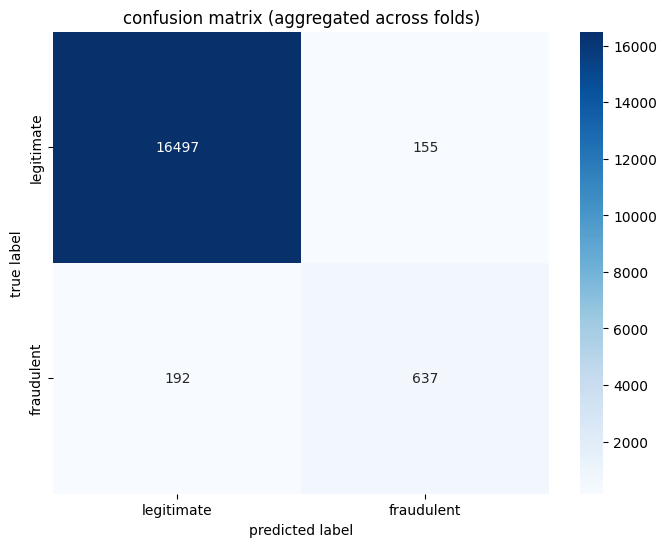


classification report:
              precision    recall  f1-score   support

  legitimate       0.99      0.99      0.99     16652
  fraudulent       0.80      0.77      0.79       829

    accuracy                           0.98     17481
   macro avg       0.90      0.88      0.89     17481
weighted avg       0.98      0.98      0.98     17481



In [13]:
# confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['legitimate', 'fraudulent'],
            yticklabels=['legitimate', 'fraudulent'])
plt.title('confusion matrix (aggregated across folds)')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()

print("\nclassification report:")
print(classification_report(all_y_true, all_y_pred, 
                          target_names=['legitimate', 'fraudulent']))

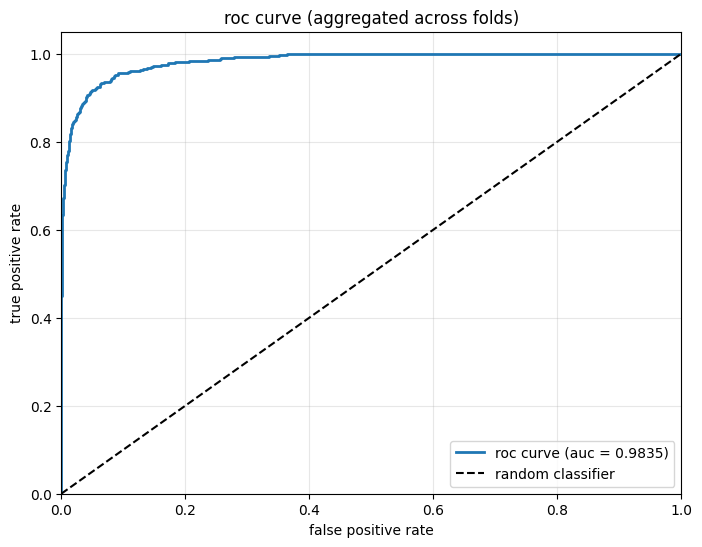

In [14]:
# roc curve
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_proba)
roc_auc_agg = roc_auc_score(all_y_true, all_y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'roc curve (auc = {roc_auc_agg:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('roc curve (aggregated across folds)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

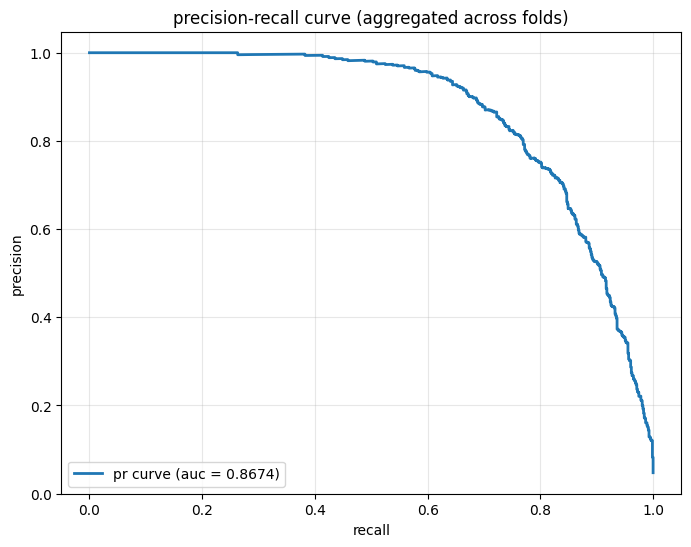

In [ ]:
# precision-recall curve
precision_vals, recall_vals, _ = precision_recall_curve(all_y_true, all_y_pred_proba)
pr_auc_agg = average_precision_score(all_y_true, all_y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'pr curve (auc = {pr_auc_agg:.4f})', linewidth=2)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve (aggregated across folds)')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

## SHAP Analysis

In [ ]:
#train final model on full train data and evaluate on test data
X_train = train_df.drop(columns=[id_col, target_col], errors='ignore')
y_train = train_df[target_col]
X_test = test_df.drop(columns=[id_col, target_col], errors='ignore')
y_test = test_df[target_col]

# identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    # get categories ONLY from training data
    train_cats = sorted(X_train[col].unique())
    
    # handle unseen categories in test: map to 'unknown'
    X_test_col = X_test[col].copy()
    unseen_mask = ~X_test_col.isin(train_cats)
    if unseen_mask.any():
        X_test_col[unseen_mask] = 'unknown'
        # add 'unknown' to train categories if it's not already there
        if 'unknown' not in train_cats:
            train_cats.append('unknown')
            train_cats = sorted(train_cats)
    
    # convert both to categorical with training categories only
    X_train[col] = pd.Categorical(X_train[col], categories=train_cats)
    X_test[col] = pd.Categorical(X_test_col, categories=train_cats)

# convert to numeric format for SMOTE
X_train_numeric = X_train.copy()
X_test_numeric = X_test.copy()

for col in categorical_cols:
    X_train_numeric[col] = X_train[col].cat.codes
    X_test_numeric[col] = X_test[col].cat.codes

# apply smote on numeric data
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_numeric, y_train)

# convert back to DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# restore categorical dtypes with aligned categories
for col in categorical_cols:
    # round the SMOTE-generated values and clip to valid range
    X_train_resampled[col] = X_train_resampled[col].round().astype(int)
    X_train_resampled[col] = X_train_resampled[col].clip(
        lower=0, 
        upper=len(X_train[col].cat.categories) - 1
    )
    X_train_resampled[col] = pd.Categorical.from_codes(
        X_train_resampled[col], 
        categories=X_train[col].cat.categories
    )

# restore categorical dtypes on X_test to match X_train_resampled
X_test_categorical = X_test.copy()
for col in categorical_cols:
    X_test_categorical[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

# train final_xgb_model
final_xgb_model = XGBClassifier(
    **best_params_final,
    enable_categorical=True,
    tree_method='hist',
    random_state=RANDOM_STATE,
    eval_metric='logloss',
)
final_xgb_model.fit(X_train_resampled, y_train_resampled, verbose=False)

# evaluate on test set using categorical data
y_test_pred_proba = final_xgb_model.predict_proba(X_test_categorical)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

/var/folders/3y/f84q724s7t14rlnffvb987z00000gn/T/ipykernel_92117/4033707818.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_plot, X_plot)


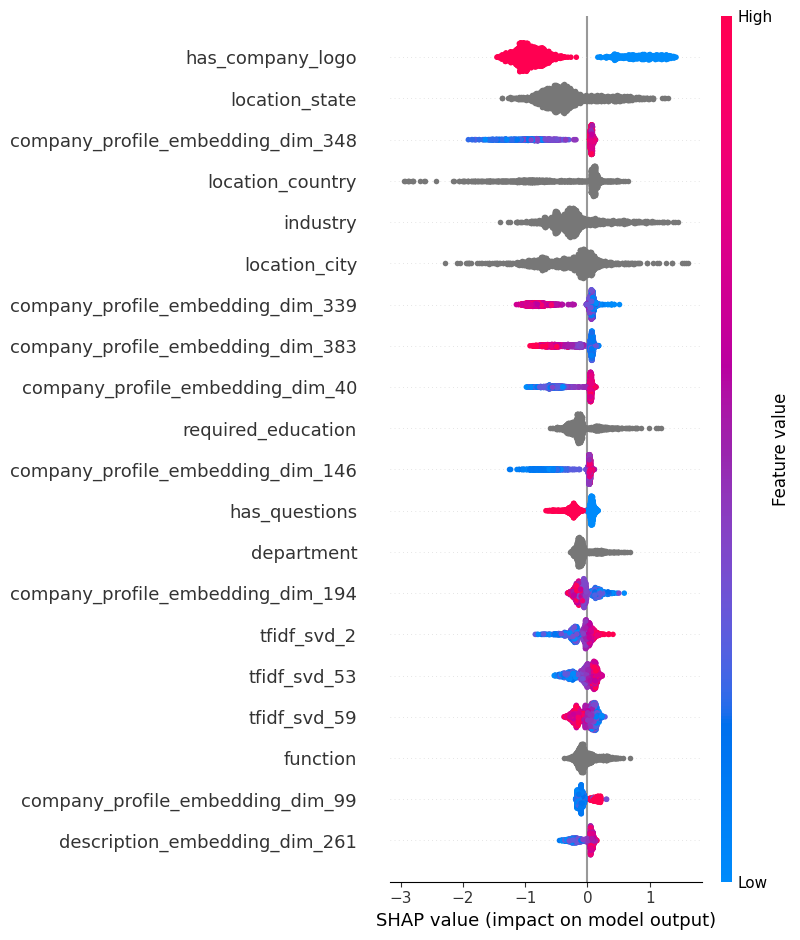

In [76]:
import shap

explainer = shap.TreeExplainer(final_xgb_model)
shap_values = explainer.shap_values(X_test_categorical)

N_SAMPLES = 1500
X_plot = X_test_categorical.head(N_SAMPLES)
shap_plot = shap_values[:N_SAMPLES, :] 

shap.summary_plot(shap_plot, X_plot)

In [73]:
import numpy as np
import pandas as pd

#group embedding feature importances
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_importance_series = pd.Series(
    mean_abs_shap, 
    index=X_test_categorical.columns
)

EMBEDDING_PREFIXES = [
    'description_embedding', 
    'company_profile_embedding', 
    'requirements_embedding', 
    'benefits_embedding',
    'tfidf_svd'
]

def group_embedding_feature(feature_name):
    """Maps an individual embedding dimension to its parent text group."""
    for prefix in EMBEDDING_PREFIXES:
        if feature_name.startswith(prefix):
            return prefix
    
    return feature_name

grouped_importance = shap_importance_series.groupby(group_embedding_feature).sum()
aggregate_embedding_importance = grouped_importance.sort_values(ascending=False)

print("\nAggregate SHAP Importance for Text Embeddings:")
print("="*50)
print(aggregate_embedding_importance)


Aggregate SHAP Importance for Text Embeddings:
company_profile_embedding        3.761292
tfidf_svd                        3.598271
description_embedding            3.301626
requirements_embedding           1.465906
benefits_embedding               0.911862
has_company_logo                 0.904353
location_state                   0.485743
location_country                 0.424667
location_city                    0.391990
industry                         0.382846
required_education               0.213844
has_questions                    0.157973
department                       0.143245
function                         0.120085
required_experience              0.087345
salary_min                       0.017156
salary_max                       0.015717
employment_type_clean            0.003541
benefits_money_symbols           0.003033
company_profile_money_symbols    0.001178
telecommuting                    0.000578
description_urls                 0.000000
requirements_emails         

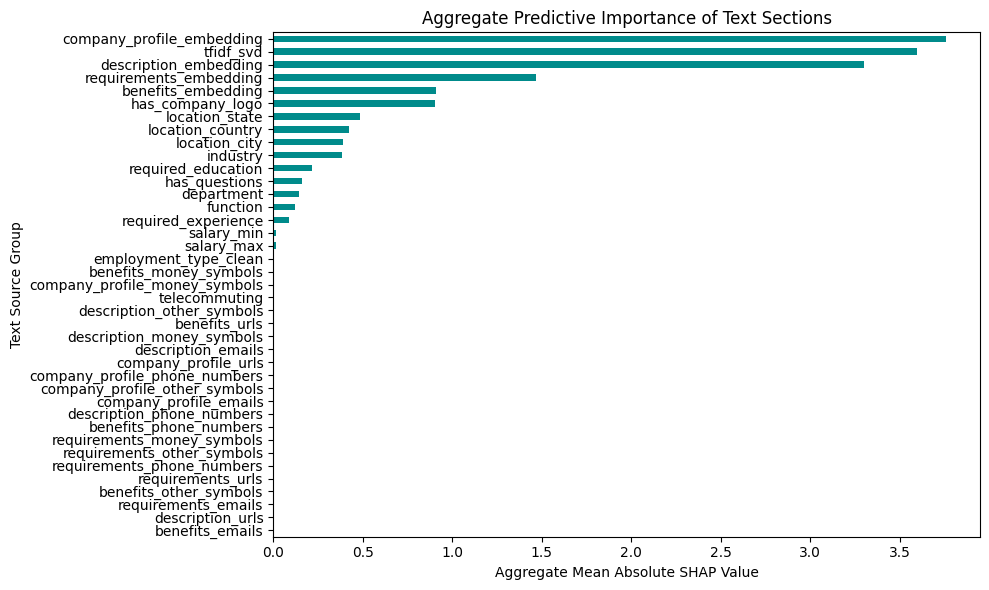

In [74]:
plt.figure(figsize=(10, 6))
aggregate_embedding_importance.sort_values(ascending=True).plot(kind='barh', color='darkcyan')
plt.xlabel('Aggregate Mean Absolute SHAP Value')
plt.ylabel('Text Source Group')
plt.title('Aggregate Predictive Importance of Text Sections')
plt.tight_layout()
plt.savefig('aggregate_importance_bar_chart.png')

In [75]:
# Calculate Cumulative Importance
total_aggregate_importance = aggregate_embedding_importance.sum()
cumulative_importance = aggregate_embedding_importance.cumsum()
cumulative_percentage = (cumulative_importance / total_aggregate_importance) * 100

def find_cutoff_info(threshold, cumulative_percentage, aggregate_embedding_importance):
    """Helper function to find the number of features and the list for a given threshold."""
    cutoff_series = cumulative_percentage[cumulative_percentage >= threshold]
    if not cutoff_series.empty:
        cutoff_index = cutoff_series.index[0]
        n_features = cumulative_percentage.index.get_loc(cutoff_index) + 1
        features_list = aggregate_embedding_importance.head(n_features)
        return n_features, features_list
    return len(aggregate_embedding_importance), aggregate_embedding_importance

# 80% Cutoff
n_features_80, features_80_percent = find_cutoff_info(80, cumulative_percentage, aggregate_embedding_importance)

# 90% Cutoff
n_features_90, features_90_percent = find_cutoff_info(90, cumulative_percentage, aggregate_embedding_importance)

print("="*70)
print(f"Total Number of Aggregated Features/Groups: {len(aggregate_embedding_importance)}")
print("--- Cumulative Aggregate Importance Analysis ---")
print(f"80% of total model importance is accounted for by the top {n_features_80} features/groups.")
print(f"90% of total model importance is accounted for by the top {n_features_90} features/groups.")
print("="*70)

print("\nFeatures/Groups Contributing to 90% Importance:")
print(features_90_percent)

Total Number of Aggregated Features/Groups: 39
--- Cumulative Aggregate Importance Analysis ---
80% of total model importance is accounted for by the top 6 features/groups.
90% of total model importance is accounted for by the top 8 features/groups.

Features/Groups Contributing to 90% Importance:
company_profile_embedding    3.761292
tfidf_svd                    3.598271
description_embedding        3.301626
requirements_embedding       1.465906
benefits_embedding           0.911862
has_company_logo             0.904353
location_state               0.485743
location_country             0.424667
dtype: float32
